# Wetland histograms

**Background**

**What does this notebook do?** This notebook generates histograms of raster properties for wetland and non-wetland regions in Queensland.

**Date**: Aug 2020.

**Author**: Matthew Alger

## Setup

Set up the notebook and load the data.

In [10]:
import functools
import os
import sys
import datacube
from datacube.storage.masking import make_mask
import datacube.utils.cog
import geopandas as gpd
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import odc.ui
from odc.ui import with_ui_cbk
import rasterio.features
from shapely.geometry import shape
from shapely.validation import explain_validity
import skimage.color as colour
import skimage.io
from tqdm.notebook import tqdm
import xarray

sys.path.append('../Scripts')
from dea_dask import create_local_dask_cluster
from dea_datahandling import load_ard, array_to_geotiff
from dea_plotting import rgb

/g/data/v10/public/modules/dea/20200617/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [11]:
tcw_conf = '/g/data/r78/datacube_stats/ls_tcw_percentiles/vmn547_cog_dev.conf'
dc = datacube.Datacube(config=tcw_conf)

In [12]:
wetlands = gpd.read_file('/g/data/r78/ma6611/Queensland_dominant_wetland_areas_22042020.shp')

In [13]:
tiles = gpd.read_file('QLDTestTiles.shp')

In [14]:
validity = wetlands.geometry.apply(lambda k: explain_validity(k) if k is not None else None)

In [15]:
invalid = validity != 'Valid Geometry'

In [16]:
# Fix invalid geometries.
fixed_wetlands = wetlands[invalid].geometry.buffer(0)
wetlands_original = wetlands
wetlands = wetlands.copy()
wetlands.loc[invalid, 'geometry'] = fixed_wetlands

## Calculate histograms

In [17]:
sampled_wetlands = wetlands.geometry.intersection(tiles.unary_union)

In [18]:
wetlands = wetlands[~sampled_wetlands.geometry.is_empty]
wetlands.loc[:, 'geometry'] = sampled_wetlands[~sampled_wetlands.geometry.is_empty]

In [19]:
# Here's some ways to get the "non-wetlands" regions that we have tiles for.
# Super super slow! Don't do this.
# Better approach is to load the raster images that we have and then mask the wetlands.

# sampled_nonwetlands = tiles.copy()
# for i in tqdm(range(len(sampled_wetlands))):
#     sampled_nonwetlands = sampled_nonwetlands.difference(wetlands.iloc[i])

# sampled_nonwetlands = gpd.overlay(tiles, wetlands, how='difference')

In [28]:
def get_tcw(tile_label):
    tif_path_base = '/g/data/r78/datacube_stats/TCW_stats/demo_tiles/output_qld_wetness/LS_TCW_PC_{}_1986_2020_summary.tif'
    tif_path = tif_path_base.format(tile_label.replace(',', '_'))
    da = xarray.open_rasterio(tif_path)
    return da

def get_tcg(tile_label):
    tif_path_base = '/g/data/r78/datacube_stats/TCW_stats/demo_tiles/output_qld_greenness/LS_TCG_PC_{}_1986_2020_summary.tif'
    tif_path = tif_path_base.format(tile_label.replace(',', '_'))
    da = xarray.open_rasterio(tif_path)
    return da

def make_wetland_mask(da):
    raster_wetland = rasterio.features.rasterize(shapes=wetlands.buffer(0),
                                                 out_shape=da.y.shape + da.x.shape,
                                                 all_touched=False,
                                                 default_value=1,
                                                 fill=0,
                                                 transform=da.geobox.transform)
    return raster_wetland.astype(bool)

In [36]:
def get_tc_data(tile_label, tc='w', band=3, bins=None) -> ('wetland', 'nonwetland'):
    if tc == 'w':
        get = get_tcw
    elif tc == 'g':
        get = get_tcg
    else:
        raise NotImplementedError(f'Unsupported TC type: {tc} (supported: w, g)')

    da = get(tile_label)
    # Rasterise this tile of wetlands so we can quickly mask.
    wetlands_mask = make_wetland_mask(da)
    # Apply the mask and get the TC data.
    tc_data = da.isel(band=band).values
    nodata = tc_data == da.nodatavals[band]
    tc_data_w = tc_data[wetlands_mask & ~nodata]
    tc_data_nw = tc_data[~wetlands_mask & ~nodata]
    
    if bins is None:
        # Just return the data. Big!
        return tc_data_w, tc_data_nw
    
    # Return a histogram of the data.
    hist_wetland, bin_edges = np.histogram(tc_data_w, bins=bins)
    assert (bin_edges == bins).all()
    hist_nonwetland, bin_edges = np.histogram(tc_data_nw, bins=bins)
    return (hist_wetland, hist_nonwetland)

In [32]:
bins = np.linspace(-4000, 4000, 120)
hist_wetland = np.zeros(len(bins) - 1, dtype=int)
hist_nonwetland = np.zeros(len(bins) - 1, dtype=int)
for tile in tqdm(tiles.itertuples(), total=len(tiles)):
    hist_wetland_, hist_nonwetland_ = get_tc_data(tile.label, tc='w', band=3, bins=bins)
    hist_wetland += hist_wetland_
    hist_nonwetland += hist_nonwetland_

In [33]:
px_to_km2 = 0.0001 # 10 m x 10 m -> 100 m^2 = 0.0001 km^2

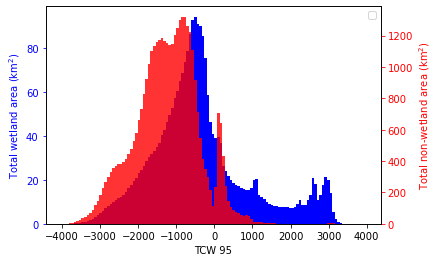

In [34]:
ax = plt.subplot(1, 1, 1)
ax.bar(bins[:-1], hist_wetland * px_to_km2, width=bins[1] - bins[0], color='blue')
ax.set_xlabel('TCW 95')
ax.set_ylabel('Total wetland area (km$^2$)', fontdict={'color': 'blue'})
ax.tick_params(axis='y', colors='blue')
ax2 = ax.twinx()
ax2.bar(bins[:-1], hist_nonwetland * px_to_km2, width=bins[1] - bins[0], color='red', alpha=0.8)
ax2.set_ylabel('Total non-wetland area (km$^2$)', fontdict={'color': 'red'})
ax2.tick_params(axis='y', colors='red')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

In [39]:
bins = np.linspace(-4000, 4000, 120)
hist_wetland = np.zeros(len(bins) - 1, dtype=int)
hist_nonwetland = np.zeros(len(bins) - 1, dtype=int)
for tile in tqdm(tiles.itertuples(), total=len(tiles)):
    try:
        hist_wetland_, hist_nonwetland_ = get_tc_data(tile.label, tc='g', band=1, bins=bins)
    except:
        continue
    hist_wetland += hist_wetland_
    hist_nonwetland += hist_nonwetland_

In [44]:
def plot_wetlands_histogram(hist_wetland, hist_nonwetland, xlabel):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(bins[:-1], hist_wetland * px_to_km2, width=bins[1] - bins[0], color='blue')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Total wetland area (km$^2$)', fontdict={'color': 'blue'})
    ax.tick_params(axis='y', colors='blue')
    ax2 = ax.twinx()
    ax2.bar(bins[:-1], hist_nonwetland * px_to_km2, width=bins[1] - bins[0], color='red', alpha=0.8)
    ax2.set_ylabel('Total non-wetland area (km$^2$)', fontdict={'color': 'red'})
    ax2.tick_params(axis='y', colors='red')

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    return fig

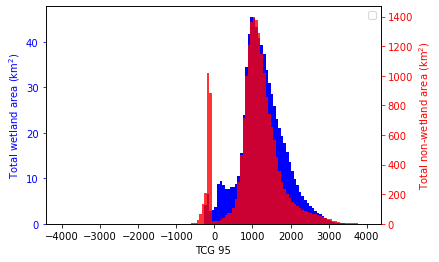

In [49]:
plot_wetlands_histogram(hist_wetland, hist_nonwetland, 'TCG 95');

In [41]:
bins = np.linspace(-4000, 4000, 120)
hist_wetland_green_50 = np.zeros(len(bins) - 1, dtype=int)
hist_nonwetland_green_50 = np.zeros(len(bins) - 1, dtype=int)
for tile in tqdm(tiles.itertuples(), total=len(tiles)):
    try:
        hist_wetland_, hist_nonwetland_ = get_tc_data(tile.label, tc='g', band=1, bins=bins)
    except:
        continue
    hist_wetland_green_50 += hist_wetland_
    hist_nonwetland_green_50 += hist_nonwetland_

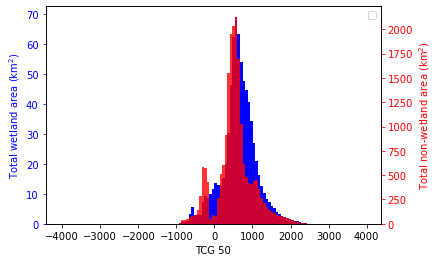

In [51]:
plot_wetlands_histogram(hist_wetland_green_50, hist_nonwetland_green_50, 'TCG 50');

In [59]:
def get_tc_data_2d(tile_label, tcs=('w', 'g'), bands=(3, 1), bins=None) -> ('wetland', 'nonwetland'):
    for tc in tcs:
        if tc not in 'wg':
            raise NotImplementedError(f'Unsupported TC type: {tc} (supported: w, g)')

    gets = {'w': get_tcw, 'g': get_tcg}
    
    data_w = []
    data_nw = []
    for tc, band in zip(tcs, bands):
        get = gets[tc]
        da = get(tile_label)
        # Rasterise this tile of wetlands so we can quickly mask.
        wetlands_mask = make_wetland_mask(da)
        # Apply the mask and get the TC data.
        tc_data = da.isel(band=band).values
        nodata = tc_data == da.nodatavals[band]
        tc_data_w = tc_data[wetlands_mask & ~nodata]
        tc_data_nw = tc_data[~wetlands_mask & ~nodata]
        data_w.append(tc_data_w)
        data_nw.append(tc_data_nw)
    
    if bins is None:
        # Just return the data. Big!
        return data_w, data_nw

    # Return a histogram of the data.
    hist_wetland, bin_edges_x, bin_edges_y = np.histogram2d(data_w[0], data_w[1], bins=bins)
    hist_nonwetland, bin_edges_x, bin_edges_y = np.histogram2d(data_nw[0], data_nw[1], bins=bins)
    return (hist_wetland, hist_nonwetland)

In [60]:
bins_w = np.linspace(-4000, 4000, 120)
bins_g = np.linspace(-1000, 3000, 120)
hist_wetland_2d, hist_nonwetland_2d = get_tc_data_2d(tiles.label[0], bins=(bins_w, bins_g))

(-1000.0, 3000.0)

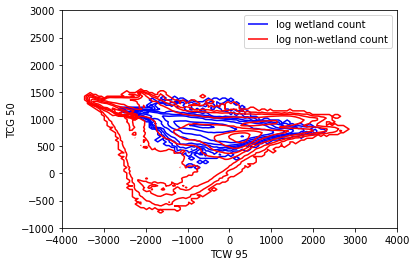

In [74]:
hw = plt.contour(bins_w[:-1], bins_g[:-1], np.log10(hist_wetland_2d + 1), colors='blue')
hnw = plt.contour(bins_w[:-1], bins_g[:-1], np.log10(hist_nonwetland_2d + 1), colors='red')
plt.legend([hw.collections[0], hnw.collections[0]], ['log wetland count', 'log non-wetland count'])
plt.xlabel('TCW 95')
plt.ylabel('TCG 50')
plt.xlim(bins_w.min(), bins_w.max())
plt.ylim(bins_g.min(), bins_g.max())

In [ ]:
bins = np.linspace(-4000, 4000, 120)
hist_wetland_green_10 = np.zeros(len(bins) - 1, dtype=int)
hist_nonwetland_green_10 = np.zeros(len(bins) - 1, dtype=int)
for tile in tqdm(tiles.itertuples(), total=len(tiles)):
    try:
        hist_wetland_, hist_nonwetland_ = get_tc_data(tile.label, tc='g', band=0, bins=bins)
    except:
        continue
    hist_wetland_green_10 += hist_wetland_
    hist_nonwetland_green_10 += hist_nonwetland_

In [ ]:
plot_wetlands_histogram(hist_wetland_green_10, hist_nonwetland_green_10, 'TCG 10');